<a href="https://colab.research.google.com/github/morwald/ada_project/blob/master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import bz2
from gensim.models import CoherenceModel

from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Comment the files which aren't stored locally
# In Colab everything should be available
QUOTES_2020_PATH = 'Merged data/quotes-2020-gb.pkl'
QUOTES_2019_PATH = 'Merged data/quotes-2019-gb.pkl' 
QUOTES_2018_PATH = 'Merged data/quotes-2018-gb.pkl'  
QUOTES_2017_PATH = 'Merged data/quotes-2017-gb.pkl'
QUOTES_2016_PATH = 'Merged data/quotes-2016-gb.pkl'
QUOTES_2015_PATH = 'Merged data/quotes-2015-gb.pkl'

In [3]:
use_colab = True

In [4]:
# Import with EPFL google drive!
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    
    %cd /content/drive/Shareddrives/ADA-project

Mounted at /content/drive
/content/drive/Shareddrives/ADA-project


In [5]:
!pip install pyldavis

# Preprocessing

We select the quotations as a list of strings

In [153]:
quotes_df = pd.read_pickle(QUOTES_2020_PATH)
doc_complete = quotes_df.quotation.tolist()

doc_complete[:3]

['As you reach or have reached the apex of your career, you build a certain level of resilience to block things out,',
 'At the same time we want to remain friends with our European neighbours and offer a range of drinks at an excellent price.',
 'Been home-schooling a 6-year-old and 8-year-old for 1 hour and 11 minutes. Teachers deserve to make a billion dollars a year. Or WEEK.']

Now we clean the quotations by removing stop words, punctuation.

In [88]:
from nltk.corpus import stopwords 
import spacy
def clean(doc):
    stopwordss = stopwords.words('english')
    stopwordss.extend(['from', 'subject', 're', 'edu', 'use'])
    stop = set(stopwordss)
    exclude = set(string.punctuation) 

    # stop words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])

    # punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)

    return punc_free



/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping, Sequence  # noqa


In [77]:
def lemmatize(doc):
    return  " ".join(lemma.lemmatize(word) for word in doc)

In [85]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load('en', disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [104]:
def remove_short_words(doc):
  return [word for word in doc if len(word)>=3]

In [105]:
def data_processing_for_lda(data):

  stopwordss = stopwords.words('english')
  stopwordss.extend(['from', 'subject', 're', 'edu', 'use'])
  stop = set(stopwordss)
  exclude = set(string.punctuation) 
  lemma = WordNetLemmatizer()

  # Remove distracting single quotes
  data = [re.sub("\'", "", doc) for doc in data]
  # remove stop words and punctuation 
  doc_no_stop_punc = [clean(doc).split() for doc in data]


 # remove short words
  doc_no_stop_punc = [remove_short_words(doc) for doc in doc_no_stop_punc]
  
   # bigrams and trigrams
  bigram = gensim.models.Phrases(doc_no_stop_punc, min_count=5, threshold=100) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[doc_no_stop_punc], threshold=100)  

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)

  bigrams = [bigram_mod[doc] for doc in doc_no_stop_punc]

  data_lemmatized = lemmatization(bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

  #lemmatize
  doc_clean = [lemmatize(doc).split() for doc in doc_no_stop_punc]
    

  return data_lemmatized

In [106]:
doc_clean = data_processing_for_lda(doc_complete)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [107]:
doc_clean[:3]

[['reach',
  'apex',
  'career',
  'build',
  'certain',
  'level',
  'resilience',
  'block',
  'thing'],
 ['time',
  'want',
  'remain',
  'friend',
  'european',
  'neighbour',
  'offer',
  'range',
  'drink',
  'excellent',
  'price'],
 ['hour', 'minute', 'teacher', 'deserve', 'make', 'dollar', 'year', 'week']]

Now we create a document term matrix from the cleaned quotations, where every unique term is assigned an index.

In [124]:
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# filter out words that appear in more than 50% of the quotes
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Models fitting and testing

Test the numbers of topics to find most efficient one

In [109]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      #(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50,workers=4)
      model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           passes=50,
                                           per_word_topics=True, 
                                           workers=6)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [110]:
modellist, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=doc_clean, start=6, limit=24, step=4)

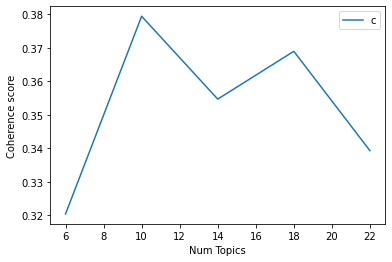

In [112]:
# Show graph
limit=24; start=6; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Choice of the best model and extraction of topics

In [113]:
optimodel = modellist[1]
coherence_values[1]

0.3793703303721529

In [114]:
optimodel.print_topics()

[(0,
  '0.035*"get" + 0.015*"play" + 0.015*"think" + 0.015*"lose" + 0.013*"big" + 0.012*"have" + 0.010*"great" + 0.010*"would" + 0.010*"s" + 0.008*"want"'),
 (1,
  '0.035*"think" + 0.017*"look" + 0.015*"say" + 0.014*"get" + 0.013*"s" + 0.013*"make" + 0.012*"want" + 0.012*"day" + 0.012*"thing" + 0.011*"time"'),
 (2,
  '0.030*"people" + 0.020*"need" + 0.013*"help" + 0.011*"take" + 0.010*"support" + 0.009*"can" + 0.008*"government" + 0.007*"problem" + 0.007*"protect" + 0.007*"could"'),
 (3,
  '0.015*"much" + 0.014*"know" + 0.009*"get" + 0.008*"time" + 0.008*"make" + 0.007*"work" + 0.007*"go" + 0.007*"still" + 0.006*"mean" + 0.006*"could"'),
 (4,
  '0.018*"know" + 0.018*"go" + 0.017*"life" + 0.015*"want" + 0.015*"happen" + 0.011*"see" + 0.008*"s" + 0.008*"have" + 0.008*"never" + 0.008*"back"'),
 (5,
  '0.015*"want" + 0.011*"stay" + 0.010*"people" + 0.010*"test" + 0.010*"away" + 0.010*"home" + 0.009*"year" + 0.008*"tell" + 0.008*"come" + 0.008*"end"'),
 (6,
  '0.036*"s" + 0.016*"people" + 0

In [115]:
import pyLDAvis
import pyLDAvis.gensim_models 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimodel, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.097986  0.016556       1        1  14.380618
2     -0.186633  0.103787       2        1  13.626066
9      0.074376  0.016042       3        1   9.695291
8      0.074857  0.001675       4        1   9.685600
3      0.010271  0.029244       5        1   9.492791
6      0.024131  0.007398       6        1   9.255179
4      0.065078 -0.044023       7        1   9.054943
7     -0.180785 -0.212096       8        1   8.489614
0      0.103958 -0.068115       9        1   8.385653
5     -0.083241  0.149532      10        1   7.934244, topic_info=      Term         Freq        Total Category  logprob  loglift
38      go  1725.000000  1725.000000  Default  30.0000  30.0000
149    say  1385.000000  1385.000000  Default  29.0000  29.0000
278  think  1665.000000  1665.000000  Default  28.0000  28.0000
196    get  1887.000000  1887.000000  Default  27.0000  27.0000
62       s  1992.000000  1992.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
216   help    83.763150   509.302803  Topic10  -5.2914   0.7289
112  could    94.967747   959.324420  Topic10  -5.1658   0.2213
207   take    94.892772  1116.766190  Topic10  -5.1666   0.0685
102  would    95.157709  1644.589432  Topic10  -5.1638  -0.3157
617   feel    78.806057   926.972050  Topic10  -5.3524   0.0690

[828 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
8082     10  0.948315   a.m.
103       1  0.184821   able
103       5  0.063731   able
103       6  0.025493   able
103       7  0.057358   able
...     ...       ...    ...
377       4  0.029307  young
377       5  0.121414  young
377       6  0.079547  young
377       9  0.096294  young
377      10  0.058614  young

[1896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 10, 9, 4, 7, 5, 8, 1, 6])

In [43]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("ldamodel")
optimodel.save(temp_file)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


We can see it is more sparse, so better than before.

Now let us see which topic is dominant for each quote :


In [116]:
def take_second(elem):
    return elem[1]

def format_topics_sentences(ldamodel=lda, corpus=doc_term_matrix, texts=doc_clean):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=take_second, reverse=True)        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [117]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=doc_term_matrix, texts=doc_clean)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [118]:
# Show random samples
for i in range(460,465):
  print('Quote : ' +doc_complete[i])
  print('topic keywords : ' + df_dominant_topic.Keywords[i] )
  print('\n')


Quote : What I sent was NSW-based advice, based on information from our lawyers. It wasnt a legal thing given by myself,
topic keywords : would, love, ive, never, thought, always, much, like, bit, think


Quote : A guy meeting Polly... I dont just do that and you met mum and everything.
topic keywords : im, get, going, go, back, could, people, cant, time, it


Quote : But hopefully we have a full set to pick from; that would be great. We have options. You might hear the five seamer option come out again but Dom Bess has done himself absolutely no harm the way he bowled down in PE. Its great to see a spinner come into our team and bowl as well as he did.
topic keywords : people, need, want, us, dont, home, everyone, come, stay, social


Quote : But I appreciate that this [ curfews ] is something we need to keep under review.
topic keywords : would, love, ive, never, thought, always, much, like, bit, think


Quote : Contrary to Prince Andrews very public offer to cooperate with our inves

The most important quote in each topic :

In [121]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8690,"people, health, many, men, future, news, world...","[know, live, inner, conflict, long, time]"
1,1.0,0.8690,"got, like, hes, new, ive, im, life, well, put, it","[write, tell, never, say, era, be]"
2,2.0,0.8690,"like, something, really, im, people, things, g...","[s, go, say, mother, say, life]"
3,3.0,0.8690,"people, need, want, us, dont, home, everyone, ...","[garin, important, voice, indonesian, cultural..."
4,4.0,0.8690,"uk, system, well, weve, many, virus, coronavir...","[try, look, bright, side, thing, great]"
5,5.0,0.9295,"really, it, im, like, got, actually, day, stil...","[admit, nearly, phone, book, phone, see, go, t..."
6,6.0,0.8854,"dont, think, people, going, want, know, thats,...","[have, get, confidence, bridget, have, clear, ..."
7,7.0,0.8854,"im, get, going, go, back, could, people, cant,...","[experience, also, last, chance, get, well, me..."
8,8.0,0.8981,"would, love, ive, never, thought, always, much...","[even, brain, dead, zombie, respect, good, fri..."
9,9.0,0.8981,"government, health, public, us, support, minis...","[know, want, die, know, would, want, leave, ch..."


In [122]:
for i in range(0,10):
  print('keywords : ' + sent_topics_sorteddf_mallet.Keywords[i])
  print('text : ' + str(sent_topics_sorteddf_mallet.Text[i]))
  print('\n')

keywords : people, health, many, men, future, news, world, black, work, first
text : ['know', 'live', 'inner', 'conflict', 'long', 'time']


keywords : got, like, hes, new, ive, im, life, well, put, it
text : ['write', 'tell', 'never', 'say', 'era', 'be']


keywords : like, something, really, im, people, things, get, it, feel, youre
text : ['s', 'go', 'say', 'mother', 'say', 'life']


keywords : people, need, want, us, dont, home, everyone, come, stay, social
text : ['garin', 'important', 'voice', 'indonesian', 'cultural', 'life']


keywords : uk, system, well, weve, many, virus, coronavirus, risk, us, first
text : ['try', 'look', 'bright', 'side', 'thing', 'great']


keywords : really, it, im, like, got, actually, day, still, one, ive
text : ['admit', 'nearly', 'phone', 'book', 'phone', 'see', 'go', 'think', 'people', 'genuinely', 'think', 'go']


keywords : dont, think, people, going, want, know, thats, like, one, thing
text : ['have', 'get', 'confidence', 'bridget', 'have', 'clear',

# Prediction of topics for each quote

In [134]:
def get_topics_keywords_dict(ldamodel, num_topics):
    topic_dict = {}
    for i in range(num_topics):
        topic_dict[i] = [word[0] for word in ldamodel.show_topic(i)]
    return topic_dict


In [ ]:
keywords_dict = get_topics_keywords_dict(optimodel, 10)
keywords_dict

In [138]:
keywords_dict_names = keywords_dict.copy()

In [139]:
keywords_dict_names["topic0"] = keywords_dict_names.pop(0)
keywords_dict_names["topic1"] = keywords_dict_names.pop(1)
keywords_dict_names["topic2"] = keywords_dict_names.pop(2)
keywords_dict_names["topic3"] = keywords_dict_names.pop(3)
keywords_dict_names["topic4"] = keywords_dict_names.pop(4)
keywords_dict_names["topic5"] = keywords_dict_names.pop(5)
keywords_dict_names["topic6"] = keywords_dict_names.pop(6)
keywords_dict_names["topic7"] = keywords_dict_names.pop(7)
keywords_dict_names["topic8"] = keywords_dict_names.pop(8)
keywords_dict_names["topic9"] = keywords_dict_names.pop(9)

In [140]:
topics = { 0 : 'topic0', 1: 'topic1', 2: 'topic2', 3:'topic3', 4:'topic4', 5:'topic5', 6:'topic6', 7:'topic7', 8:'topic', 9:'topic9'}

In [195]:
def append_topic(ldamodel, corpus, quotes, kwdict, topics):
    quotes_topics_df = pd.DataFrame()
    
    for i, row in enumerate(ldamodel[corpus]):
        sorted_topics = sorted(row[0], key=lambda x: - x[1])
        top_topic, top_topic_proba = sorted_topics[0]
        topic1_name = topics.get(top_topic)
        topic1_keywords = ','.join(kwdict.get(top_topic))
        
        new_row = [int(top_topic), topic1_name, round(top_topic_proba,2), topic1_keywords]
        quotes_topics_df = quotes_topics_df.append(pd.Series(new_row), ignore_index=True)

    quotes_topics_df.columns = ['Topic_num', 'Topic_Name', 'Topic_Contrib', 'Topic_Keywords']
    
    return quotes_topics_df



In [194]:
all_quotes_topics_df = append_topic(ldamodel=optimodel, 
                                      corpus=doc_term_matrix, 
                                      quotes=doc_clean, 
                                      kwdict=keywords_dict,
                                      topics = topics)
all_quotes_topics_df.head()

,Topic,Topic_Name,Topic_Contrib,Topic_Keywords,Quote_id
0,2.0,topic2,0.52,"people,need,help,take,support,can,government,p...",0
1,5.0,topic5,0.47,"want,stay,people,test,away,home,year,tell,come...",1
2,0.0,topic0,0.43,"get,play,think,lose,big,have,great,would,s,want",2
3,8.0,topic,0.50,"go,really,s,thing,make,say,team,think,come,do",3
4,2.0,topic2,0.49,"people,need,help,take,support,can,government,p...",4


In [198]:
final_quotes_2020 = pd.concat([quotes_df,all_quotes_topics_df], axis=1)
final_quotes_2020.head()

,quoteID,quotation,speaker,gender,nationality,occupation,qid,date,numOccurrences,urls,newspapers,Topic,Topic_Name,Topic_Contrib,Topic_Keywords,Quote_id
0,2020-01-31-008580,As you reach or have reached the apex of your ...,Keyon Dooling,[male],[United States of America],[basketball player],Q304349,2020-01-31 19:07:55,1,[https://www.theguardian.com/sport/2020/jan/31...,[The Guardian],2.0,topic2,0.52,"people,need,help,take,support,can,government,p...",0
1,2020-01-20-006469,At the same time we want to remain friends wit...,Tim Martin,[male],None,[American football player],Q20670776,2020-01-20 09:08:24,4,[https://www.dailystar.co.uk/real-life/wethers...,[The Sun],5.0,topic5,0.47,"want,stay,people,test,away,home,year,tell,come...",1
2,2020-04-03-006933,Been home-schooling a 6-year-old and 8-year-ol...,Shonda Rhimes,[female],[United States of America],"[film director, screenwriter, writer, film pro...",Q242329,2020-04-03 16:00:00,1,[http://www.thetimes.co.uk/edition/magazine/ca...,[The Times],0.0,topic0,0.43,"get,play,think,lose,big,have,great,would,s,want",2
3,2020-04-15-018814,I am now in agreement that we should move forw...,David Boies,[male],[United States of America],[lawyer],Q5231515,2020-04-15 15:46:38,1,[https://www.thesun.co.uk/news/11403669/jeffre...,[The Sun],8.0,topic,0.50,"go,really,s,thing,make,say,team,think,come,do",3
4,2020-02-16-014286,I don't want to make a career out of [ remakin...,Ramiro Gomez,[male],None,[artist],Q30693403,2020-02-16 15:00:32,1,[https://www.theguardian.com/artanddesign/2020...,[The Guardian],2.0,topic2,0.49,"people,need,help,take,support,can,government,p...",4


In [200]:
pd.to_pickle(final_quotes_2020, 'quotes_2020_topics')